In [1]:
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from tqdm import tqdm

In [2]:
ngram_abstracts = np.load("files/ngram_abstracts.npy", mmap_mode="r")
ngram_abstracts = [ab.split() for ab in ngram_abstracts]
concept_arr = np.load("files/overlapping_concepts.npy")

In [3]:
ngram_abstracts[0]

['supplement',
 'paper',
 'arxivqbio',
 'containing',
 'text',
 'correspondence',
 'sent',
 'nature']

In [4]:
# def compute_word_count_subset(corpus, subset_words):
#     word_count = {}
#     for document in tqdm(corpus):
#         for word in document:
#             if word in subset_words:
#                 if word in word_count:
#                     word_count[word] += 1
#                 else:
#                     word_count[word] = 1
#     return word_count


# # Compute word count for the subset of words
# word_count_subset = compute_word_count_subset(ngram_abstracts, concept_arr)

In [5]:
# len(word_count_subset),len(concept_arr)

In [6]:
# # plt.hist(word_count_subset.values(),range=[0,100])
# cnt = 0
# cutoff = 0
# for v in word_count_subset.values():
#     if v > cutoff:
#         cnt += 1
# print("Cutoff at",cutoff,"still contains ", np.round(cnt/len(concept_arr)*100,2), "percent of concepts")

In [7]:
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=5,
                     window=15,
                     vector_size=128,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)

In [8]:
from gensim.utils import RULE_DEFAULT, RULE_KEEP

# Define important words
phys_concept_dict = {k:1 for k in concept_arr}

# Custom rule function
def custom_rule(word, count, min_count):
    if word in phys_concept_dict:
        return RULE_KEEP
    else:
        return RULE_DEFAULT

In [9]:
# init callback class
class LossLogger(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.losses.append(loss)
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            self.losses.append(loss- self.loss_previous_step)
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [10]:
loss_logger = LossLogger()
w2v_model.build_vocab(ngram_abstracts)#, trim_rule=custom_rule)
# w2v_model.build_vocab([[c] for c in  concept_arr],update=True)

w2v_model.train(ngram_abstracts, total_examples=w2v_model.corpus_count, epochs=2, report_delay=1,compute_loss=True,callbacks=[loss_logger])
# w2v_model.save("w2v_model_trained_stop_1.model")

Loss after epoch 0: 2509904.75
Loss after epoch 1: 1871771.25


(14364077, 20334120)

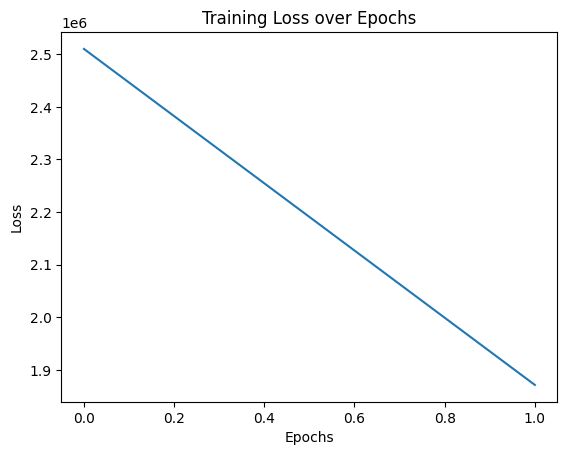

In [11]:
# Plot the training loss
plt.plot(loss_logger.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


In [12]:
w2v_model.wv.index_to_key

['state',
 'quantum',
 'result',
 'model',
 'time',
 'classical',
 'study',
 'method',
 'interaction',
 'system',
 'case',
 'measurement',
 'dynamic',
 'based',
 'approach',
 'entanglement',
 'potential',
 'present',
 'different',
 'property',
 'problem',
 'parameter',
 'effect',
 'work',
 'new',
 'number',
 'scheme',
 'field',
 'demonstrate',
 'process',
 'phase',
 'order',
 'atom',
 'qubits',
 'application',
 'experimental',
 'theory',
 'bound',
 'paper',
 'term',
 'spin',
 'coupling',
 'use',
 'temperature',
 'general',
 'experiment',
 'local',
 'regime',
 'protocol',
 'condition',
 'mode',
 'photon',
 'particle',
 'n',
 'shown',
 'particular',
 'energy',
 'provide',
 'propose',
 'large',
 'set',
 'algorithm',
 'control',
 'limit',
 'd',
 'single',
 'hamiltonian',
 'given',
 'obtained',
 'example',
 'rate',
 'possible',
 'consider',
 'investigate',
 'technique',
 'measure',
 'proposed',
 'discus',
 'noise',
 'way',
 'device',
 'solution',
 'class',
 'numerical',
 'value',
 'evolutio

In [13]:
cnt = 0 
for c in concept_arr:
    try:
        w2v_model.wv.get_vector(c)
        cnt += 1 
    except:
        pass

cnt,len(concept_arr)

(27152, 27152)

In [14]:
print("Similarity: ")
print("A superconductor is similar to: ")
for s in w2v_model.wv.most_similar(positive=['superconductor'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("Majorana is similar to: ")
for s in w2v_model.wv.most_similar(positive=['majorana'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))

print("Topological is similar to: ")    
for s in w2v_model.wv.most_similar(positive=['topological'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))

print("A phonon is similar to: ")
for s in w2v_model.wv.most_similar(positive=['phonon'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))

print("Entanglement is similar to: ")
for s in w2v_model.wv.most_similar(positive=['entanglement'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))



Similarity: 
A superconductor is similar to: 
   [*] crystalline                         	 (0.9938371181488037)
   [*] spin_current                        	 (0.9886897802352905)
   [*] doping                              	 (0.9884101748466492)
   [*] interlayer                          	 (0.9875860214233398)
   [*] band_structure                      	 (0.9874622821807861)
Majorana is similar to: 
   [*] topologically                       	 (0.9773989915847778)
   [*] majorana_fermion                    	 (0.9584035277366638)
   [*] timereversal                        	 (0.9508100748062134)
   [*] protected                           	 (0.9499342441558838)
   [*] symmetryprotected                   	 (0.9463845491409302)
Topological is similar to: 
   [*] topological_phase                   	 (0.9793273210525513)
   [*] topology                            	 (0.9610503315925598)
   [*] topologically                       	 (0.9509503245353699)
   [*] nonabelian                          

In [15]:
print("\n")
print("Arithmetics: ")
print("Majorana + Braiding = ")
for s in w2v_model.wv.most_similar(positive=['majorana', 'braiding'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("particle + charge = ")
for s in w2v_model.wv.most_similar(positive=['particle', 'charge'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("electron - charge = ")
for s in w2v_model.wv.most_similar(positive=['electron', 'positive'], negative=['negative'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("electrons + magnetic field = ")
for s in w2v_model.wv.most_similar(positive=['electron', 'magnetic_field'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))

print("Electron + Hole = ")
for s in w2v_model.wv.most_similar(positive=['electron', 'hole'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("Superconductor + Topological = ")
for s in w2v_model.wv.most_similar(positive=['superconductor', 'topological'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))
    
print("Spin + Magnetic Field = ")
for s in w2v_model.wv.most_similar(positive=['spin', 'magnetic_field'], topn=5):
    print("   [*] {0:35} \t ({1})".format(s[0], s[1]))



Arithmetics: 
Majorana + Braiding = 
   [*] majorana_fermion                    	 (0.9701191782951355)
   [*] symmetryprotected                   	 (0.9691734313964844)
   [*] anyons                              	 (0.9540262818336487)
   [*] spt                                 	 (0.9510944485664368)
   [*] protected                           	 (0.9502934217453003)
particle + charge = 
   [*] moving                              	 (0.9413648843765259)
   [*] magnetic_field_perpendicular        	 (0.9339048266410828)
   [*] quantized                           	 (0.9251707792282104)
   [*] rise                                	 (0.9179664254188538)
   [*] wall                                	 (0.91544109582901)
electron - charge = 
   [*] charged_particle                    	 (0.800824761390686)
   [*] riemannsilberstein                  	 (0.7860878109931946)
   [*] circuit_quantization                	 (0.7809557318687439)
   [*] qed                                 	 (0.7743305563926697